In [32]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

In [27]:
#!pip install tensorflow

### Step -2b: LSTM

In [33]:


def processtweets(dirPath, limitStr):
    # Convert the limit argument from a string to an int
    limit = int(limitStr)
    # Initialize NLTK built-in tweet tokenizer
    twtokenizer = TweetTokenizer()

    os.chdir(dirPath)

    f = open('./downloaded-tweeti-b-dist.tsv', 'r')
    # Loop over lines in the file and use the first limit of them
    # Assuming that the tweets are sufficiently randomized
    tweetdata = []
    for line in f:
        if len(tweetdata) < limit:
            # Remove final end of line character
            line = line.strip()
            # Each line has 4 items separated by tabs
            # Ignore the tweet and user ids, and keep the sentiment and tweet text
            tweetdata.append(line.split('\t')[2:4])
    def decontracted(phrase):
    
         # specific
        phrase = re.sub(r"won\'t", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)

        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        return phrase
    
    tweetdocs = []
    for tweet in tweetdata:
        if tweet[1] != 'Not Available':
            tokens = twtokenizer.tokenize(tweet[1])
            tokens = [token.lower() for token in tokens]
            tokens = [re.sub(':\)','happy', token) for token in tokens]
            tokens = [re.sub(':\(','sad', token) for token in tokens]
            tokens = [re.sub(r"http\S+",'',token) for token in tokens]
            tokens = [re.sub(r"@\S+", "", token) for token in tokens]
            tokens = [token for token in tokens if token]
            tokens = [token for token in tokens if token not in string.punctuation]
            tokens = [re.sub(r'\S*\d\S*', '', token) for token in tokens]
            tokens = [decontracted(token) for token in tokens]
            stop_words = set(stopwords.words('english'))
            tokens = [token for token in tokens if token not in stop_words]
            lemmatizer = WordNetLemmatizer()
            tokens = [lemmatizer.lemmatize(token) for token in tokens]
            tokens = [token for token in tokens if token]

            if tweet[0] == '"positive"':
                label = 'pos'
            elif tweet[0] == '"negative"':
                label = 'neg'
            else:
                label = 'neu'
            tweetdocs.append((tokens, label))
    
    # Create a list of tweet texts
    tweets = [tweet[0] for tweet in tweetdocs]

    # Tokenize the tweets
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(tweets)
    sequences = tokenizer.texts_to_sequences(tweets)

    # Pad the sequences to have the same length
    max_sequence_length = max(len(seq) for seq in sequences)
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

    # Create a dictionary mapping words to their index in the tokenizer
    word_index = tokenizer.word_index

    # Convert labels to numeric values
    labels = [tweet[1] for tweet in tweetdocs]
    label_mapping = {'pos': 1, 'neg': 0, 'neu': 2}

    # Convert the labels to numeric values
    numeric_labels = np.array([label_mapping[label] for label in tuple(labels)])

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(padded_sequences, numeric_labels, test_size=0.2,
                                                        random_state=42)

    # Define the LSTM model
    embedding_dim = 100
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, embedding_dim, input_length=max_sequence_length))
    model.add(LSTM(128))
    model.add(Dense(3, activation='softmax'))

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print('Accuracy:', accuracy)

    # Show precision, recall, and F1-score

    # Convert the numeric labels back to their original values
    inverse_label_mapping = {v: k for k, v in label_mapping.items()}
    y_test_original = np.array([inverse_label_mapping[label] for label in y_test])

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_pred_original = np.array([inverse_label_mapping[label] for label in y_pred_labels])

    # Calculate precision, recall, and F1-score using scikit-learn metrics
    precision = metrics.precision_score(y_test_original, y_pred_original, average='weighted')
    recall = metrics.recall_score(y_test_original, y_pred_original, average='weighted')
    f1_score = metrics.f1_score(y_test_original, y_pred_original, average='weighted')

    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1_score)

    # Visualize training and testing metrics
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper right')

    # Adjust the layout
    plt.tight_layout()

    # Show the plot
    plt.show()

Epoch 1/10
206/206 [==============================] - 10s 41ms/step - loss: 0.9116 - accuracy: 0.5728 - val_loss: 0.7962 - val_accuracy: 0.6650
Epoch 2/10
206/206 [==============================] - 6s 31ms/step - loss: 0.4958 - accuracy: 0.8000 - val_loss: 0.8115 - val_accuracy: 0.6541
Epoch 3/10
206/206 [==============================] - 7s 32ms/step - loss: 0.2129 - accuracy: 0.9235 - val_loss: 1.1204 - val_accuracy: 0.6498
Epoch 4/10
206/206 [==============================] - 7s 35ms/step - loss: 0.1109 - accuracy: 0.9641 - val_loss: 1.3350 - val_accuracy: 0.6565
Epoch 5/10
206/206 [==============================] - 7s 36ms/step - loss: 0.0651 - accuracy: 0.9799 - val_loss: 1.3262 - val_accuracy: 0.6200
Epoch 6/10
206/206 [==============================] - 7s 32ms/step - loss: 0.0377 - accuracy: 0.9912 - val_loss: 1.6194 - val_accuracy: 0.6096
Epoch 7/10
206/206 [==============================] - 6s 31ms/step - loss: 0.0325 - accuracy: 0.9904 - val_loss: 1.8835 - val_accuracy: 0.631

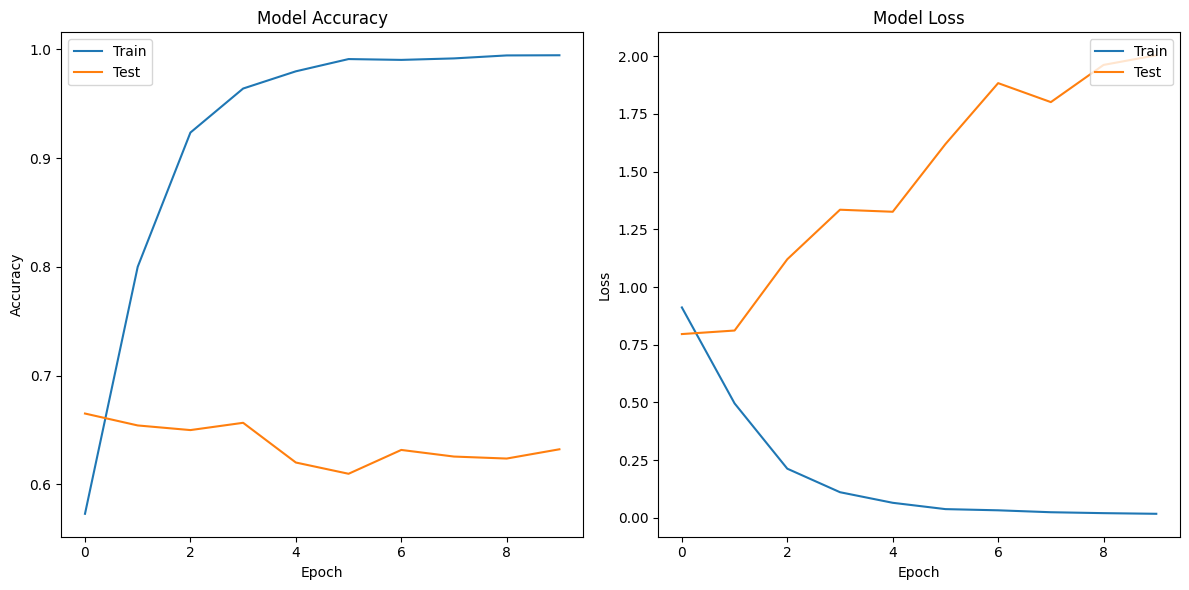

In [34]:
tweetdocs = processtweets('.',10000)